In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error, r2_score
from patsy import dmatrix # constructs design matrix
import statsmodels.api as sm

In [24]:
boston = fetch_openml(name="boston", version=1, as_frame=True)
display(boston.frame.head())
df = boston.frame[['LSTAT' ,  'MEDV']].copy()
df.columns = ['X', 'Y']

# Sort data by predictor (X = lstat)
df = df.sort_values(by='X').reset_index(drop=True)
display(df.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


,X,Y
0,1.73,50.0
1,1.92,50.0
2,1.98,34.9
3,2.47,41.7
4,2.87,36.4


In [25]:
X=df['X']
y=df['Y']

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

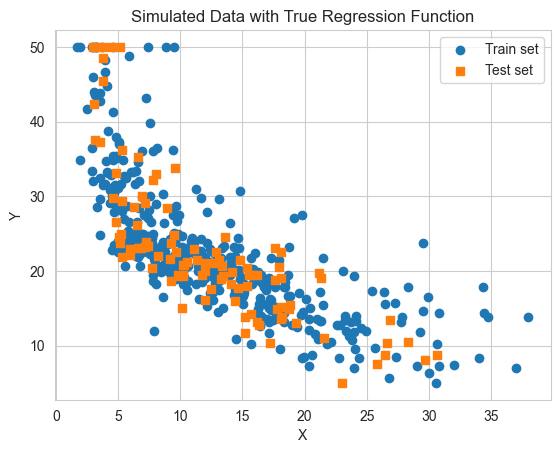

In [27]:
plt.scatter(X_train, y_train, marker='o', label='Train set')
plt.scatter(X_test, y_test, marker='s', label='Test set')

plt.xlabel('X'); plt.ylabel('Y')
plt.legend()
plt.title('Simulated Data with True Regression Function')
# plt.grid(True)
plt.show()

In [28]:
kf = KFold(n_splits=5)
K= [4,5,10,20,30,40,50]

In [32]:
Res = []
for train_index,test_index in kf.split(X,y):
    errs = []
    for k in K:
        X_train,X_test,y_train,y_test = X.iloc[train_index],X[test_index],y[train_index],y[test_index]
        X_spline = dmatrix(f"bs(X, df={k})", data={"X": X_train}, return_type='dataframe')
        model = sm.OLS(y_train, X_spline).fit() # Fitting the model
        # print(model.summary())
        X_spline = dmatrix(f"bs(X, df={k}, include_intercept=False)", data={"X": X_train}, return_type='dataframe')
        model = sm.OLS(y_train, X_spline).fit() # Fitting the model

        X_spline_test = dmatrix(f"bs(X, df={k}, include_intercept=False)", data={"X": X_test}, return_type='dataframe')
        y_pred_train = model.predict(X_spline)
        y_pred_test = model.predict(X_spline_test)

        mse_trn = mean_squared_error(y_train, y_pred_train)
        mse_tst = mean_squared_error(y_test, y_pred_test)
        
        errs.append([mse_trn , mse_tst])
    
    Res.append(errs)

Res_df = pd.DataFrame(np.mean(Res, axis=0), columns=['Avg Train MSE', 'Avg Test MSE'])
Res_df.insert(loc=0, column='k', value=K)
Res_df

,k,Avg Train MSE,Avg Test MSE
0,4,26.749535,237.001523
1,5,26.765450,208.916396
2,10,26.047259,166.421039
3,20,25.296224,152.461216
4,30,24.938593,153.007317
5,40,24.091137,172.250106
6,50,23.722246,175.376102


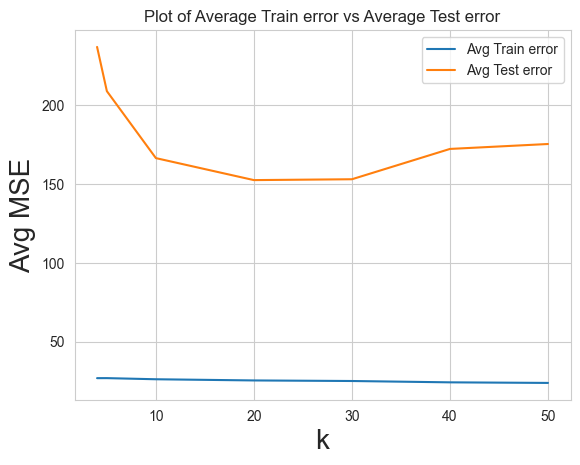

In [34]:
plt.plot(Res_df['k'], Res_df['Avg Train MSE'],label='Avg Train error')
plt.plot(Res_df['k'], Res_df['Avg Test MSE'],label='Avg Test error')
plt.xlabel('k', fontsize=20); plt.ylabel('Avg MSE', fontsize = 20)
plt.title('Plot of Average Train error vs Average Test error')
plt.legend()

In [42]:
best_k = Res_df['k'][np.argmin(Res_df['Avg Test MSE'])]
print(f"The best choice of df :{best_k}")

The best choice of df :20


In [43]:


# computing the design matrix B for B-spline basis
X_spline = dmatrix(f"bs(X, df={best_k}, include_intercept=False)", data={"X": X_train}, return_type='dataframe')
model = sm.OLS(y_train, X_spline).fit() # Fitting the model

X_spline_test = dmatrix(f"bs(X, df={best_k}, include_intercept=False)", data={"X": X_test}, return_type='dataframe')
y_pred_train = model.predict(X_spline)
y_pred_test = model.predict(X_spline_test)

mse_trn = mean_squared_error(y_train, y_pred_train)
mse_tst = mean_squared_error(y_test, y_pred_test)

print(f'df = {k}\nTrain MSE = {mse_trn}\nTest MSE = {mse_tst}')

df = 50
Train MSE = 27.371235069901434
Test MSE = 190.73380578459495
